<h1 align='center'>Combinando Diferentes Modelos de Aprendizagem em Conjunto</h1>

<p align='center'><img src=https://static.wixstatic.com/media/06b15b_1c6e7022e72b4ad6b1629b3be2129020~mv2.jpg/v1/fill/w_1000,h_667,al_c,q_90,usm_0.66_1.00_0.01/06b15b_1c6e7022e72b4ad6b1629b3be2129020~mv2.jpg width='500'></p>

<p align='justify'>Já temos uma noção sobre as melhores práticas para ajustar e avaliar diferentes modelos para classificação. Agora, desenvolveremos essas técnicas e exploraremos diferentes métodos para construir um conjunto de classificadores que muitas vezes podem ter um desempenho preditivo melhor do que qualquer um de seus membros individuais.</p>

<h2>Aprendendo com conjuntos</h2>

<p align='justify'>O objetivo dos métodos <i>ensemble</i> é combinar diferentes classificadores em um metaclassificador que tenha o melhor desempenho de generalização do que cada classificador individual sozinho. Por exemplo, suponhamos que coletamos previsões de 10 especialistas, os métodos de conjunto nos permitiriam combinar estrategicamente essas previsões dos 10 especialistas para chegar a uma previsão mais precisa e robusta do que as previsões de cada especialista individual. Como veremos a frente, existem várias abordagens diferentes para criar um conjunto de classificadores. Neste momento, apresentaremos uma explicação básica de como os <i>ensembles</i> funcionam e por que eles são normalmente reconhecidos por produzirem um bom desempenho de generalização.</p>

<p align='justify'>Vamos nos concentrar nos métodos de <i>ensemble</i> mais populares que usam o <b>princípio da votação majoritária</b>. A votação por maioria significa simplesmente que selecionamos o rótulo de classe que foi previsto pela maioria dos classificadores, ou seja, que recebeu mais de 50% dos votos. Estritamente falando, o termo "voto da maioria" refere-se apenas a configurações de classe binária. No entanto, é fácil generalizar o princípio de votação por maioria para configurações multiclasse, o que é chamado de votação por pluralidade. Aqui, selecionamos o rótulo da classe que recebeu mais votos (a moda). O diagrama a seguir ilustra o conceito de votação por maioria e pluralidade para um conjunto de 10 classificadores, onde cada símbolo único (triângulo, quadrado e círculo) representa um rótulo de classe exclusivo:</p>

<p align='center'><img src= http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier_files/voting.png width='500'></p>

<p align='justify'>Usando o conjunto de dados de treinamento, começamos treinando <i>m</i> classificadores diferentes (𝐶1, … , 𝐶𝑚 ). Dependendo da técnica, o <i>ensemble</i> pode ser construído a partir de diferentes algoritmos de classificação, por exemplo, árvores de decisão, máquinas de vetores de suporte (<i>SVM</i>), classificadores de regressão logística e assim por diante. Alternativamente, também podemos usar o mesmo algoritmo de classificação base, ajustando diferentes subconjuntos do conjunto de dados de treinamento. Um exemplo proeminente dessa abordagem é o algoritmo de floresta aleatória (<i>Random Forest</i>), que combina diferentes classificadores de árvores de decisão. A figura a seguir, ilustra o conceito de uma abordagem geral de conjunto usando votação por maioria:</p>


<p align='center'><img src= http://rasbt.github.io/mlxtend/user_guide/classifier/EnsembleVoteClassifier_files/majority_voting.png width='500'></p>

<h2>Combinando classificadores via voto majoritário</h2>

<p align='justify'>Após a breve introdução ao <i>ensemble learning</i>, vamos começar com um exercício de aquecimento e implementar um classificador de ensemble simples para votação majoritária em <i>Python</i>.

<blockquote>
<h5>Votação de pluralidade</h5>
<p align='justify'>Embora o algoritmo de votação por maioria que discutiremos nesta seção também generalize para configurações multiclasse via votação por pluralidade, o termo "votação por maioria" será usado para simplificar, como é frequentemente o caso na literatura.</p>
</blockquote>


<h3>Usando o princípio de votação por maioria para fazer previsões</h3>

<p align='justify'>Vamos testar o <i>EnsembleVoteClassifier</i> da biblioteca <i>mlxtender</i> no conjunto de dados Iris:</p>

In [9]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [11]:
from mlxtend.classifier import EnsembleVoteClassifier

# Usando a EnsembleVoteClassifier da mlxtender
mv_clf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], weights=[1,1,1]) 

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.97 (+/- 0.10) [Majority voting]


<p align='justify'>Como você pode ver, o desempenho do <i>EnsembleVoteClassifier</i> melhorou em relação aos classificadores individuais na avaliação de validação cruzada de 10 vezes.</p>

<h3>Avaliando e ajustando o classificador ensemble</h3>

<p align='justify'>Vamos calcular as curvas ROC do conjunto de dados de teste para verificar se <i>EnsembleVoteClassifier</i> generaliza bem com dados não vistos. Devemos lembrar que o conjunto de dados de teste não deve ser usado para seleção de modelo; seu propósito é meramente relatar uma estimativa imparcial do desempenho de generalização de um sistema classificador:</p>

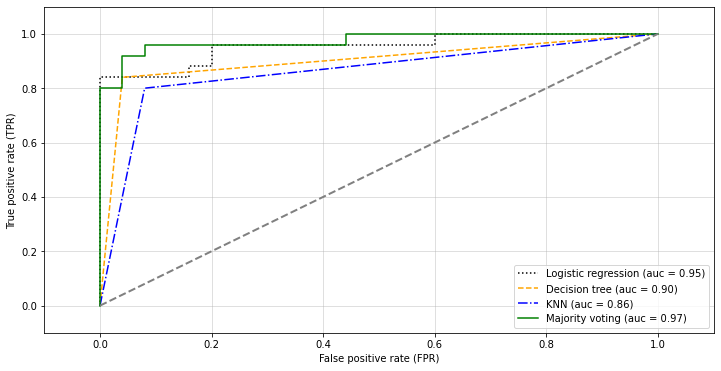

In [12]:
from matplotlib import pyplot as plt 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

plt.figure(figsize=(12,6))
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

<p align='justify'>Como você pode ver no ROC resultante, o classificador <i>ensemble</i> também tem um bom desempenho no conjunto de dados de teste (ROC AUC = 0,97). Caso algum classificador tivesse dado o mesmo resultad, poderíamos inferir que foi devido à alta variância (<i>overfitting</i>) por termos um conjunto de dados de tamanho pequeno.</p>

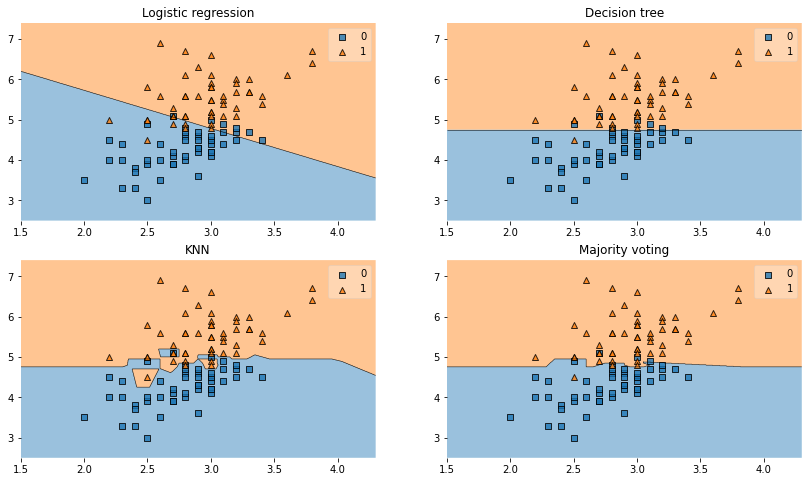

In [13]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(14,8))

clf_labels += ['Majority voting']
for clf, lab, grd in zip([pipe1, clf2, pipe3, mv_clf],
                         clf_labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, zoom_factor=2.)
    plt.title(lab)

<p align='justify'>Antes de ajustarmos os parâmetros do classificador individual para classificação de conjunto, vamos chamar o método <i>get_params</i> para ter uma ideia básica de como podemos acessar os parâmetros individuais dentro de um objeto <i>GridSearchCV</i>:</p>

In [14]:
mv_clf.get_params()

{'logisticregression': LogisticRegression(C=0.001, random_state=1),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'kneighborsclassifier': KNeighborsClassifier(n_neighbors=1),
 'logisticregression__C': 0.001,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': 1,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False,
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,

<p align='justify'>Com base nos valores retornados pelo método <i>get_params</i>, agora sabemos como acessar os atributos do classificador individual. Vamos agora ajustar o parâmetro de regularização inversa, <i>C</i>, do classificador de regressão logística e a profundidade da árvore de decisão por meio de um <i>Grid Search</i> para fins de demonstração:</p>

In [15]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'logisticregression__C': [0.001, 0.1, 100.0],
          }

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'logisticregression__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'logisticregression__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'logisticregression__C': 100.0}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'logisticregression__C': 0.001}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'logisticregression__C': 0.1}
0.967 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'logisticregression__C': 100.0}


In [16]:
print('Melhores parâmetros: %s' % grid.best_params_)
print('Acurácia: %.2f' % grid.best_score_)

Melhores parâmetros: {'decisiontreeclassifier__max_depth': 1, 'logisticregression__C': 0.001}
Acurácia: 0.97


<p align='justify'>Como você pode ver, obtivemos os melhores resultados de validação cruzada quando escolhemos uma força de regularização menor (C=0,001), enquanto a profundidade da árvore não parece afetar o desempenho em nada, sugerindo que um galho da árvore de decisão é suficiente para separar o dados. Para nos lembrar de que é uma prática ruim usar o conjunto de dados de teste mais de uma vez para avaliação do modelo, não estimaremos o desempenho de generalização dos hiperparâmetros ajustados. Vamos avançar rapidamente para uma abordagem alternativa para a aprendizagem em conjunto: <i> bagging</i>.</p>

<h3><i>Bagging</i> – construindo um conjunto de classificadores a partir de amostras bootstrap</h4>

<p align='justify'><i>Bagging</i> é uma técnica de aprendizado de conjunto que está intimamente relacionada ao <i>EnsembleVoteClassifier</i> que implementamos na seção anterior. No entanto, em vez de usar o mesmo conjunto de dados de treinamento para ajustar os classificadores individuais no conjunto, desenhamos amostras de <i>bootstrap</i> (amostras aleatórias com substituição) do conjunto de dados de treinamento inicial, razão pela qual o <i>bagging</i> também é conhecido como agregação de <i>bootstrap</i>.</p>

<p align='center'><img src= https://static.packt-cdn.com/products/9781783555130/graphics/3547_07_06.jpg ></p>


<h4>Embalagens em poucas palavras</h4>

<p align='justify'>Para fornecer um exemplo mais concreto de como funciona a agregação de <i>bootstrap</i> de um classificador <i>bagging</i>, vamos considerar o exemplo mostrado na figura a seguir. Aqui, temos sete instâncias de treinamento diferentes (indicadas como índices 1-7) que são amostradas aleatoriamente com reposição em cada rodada de <i>bagging</i>. Cada amostra de <i>bootstrap</i> é então usada para ajustar um classificador, 𝐶𝑗, que normalmente é uma árvore de decisão não podada:</p>


<p align='center'><img src= https://sebastianraschka.com/images/faq/bagging-boosting-rf/bagging.png></p>


<p align='justify'>Como você pode ver na ilustração anterior, cada classificador recebe um subconjunto aleatório de exemplos do conjunto de dados de treinamento. Denominamos essas amostras aleatórias obtidas por meio de <i>bagging</i> como <b>Bagging Round 1</b>, <b>Bagging Round 2</b> e assim por diante. Cada subconjunto contém uma determinada porção de duplicatas e alguns dos exemplos originais não aparecem em um conjunto de dados reamostrado devido à amostragem com substituição. Uma vez que os classificadores individuais estejam ajustados às amostras <i>bootstrap</i>, as previsões são combinadas usando votação majoritária.
Observe que o <i>bagging</i> também está relacionado ao classificador de floresta aleatória. Na verdade, as florestas aleatórias são um caso especial de <i>bagging</i>, onde também usamos subconjuntos de recursos aleatórios ao ajustar as árvores de decisão individuais.</p>

<h4>Aplicando o <i>bagging</i> para classificar exemplos no conjunto de dados do Wine</h4>
<p align='justify'>Para ver o <i>bagging</i> em ação, vamos criar um problema de classificação mais complexo usando o conjunto de dados <i>Wine</i>. Aqui, consideraremos apenas as classes de vinhos 2 e 3, e selecionaremos duas características – Álcool e OD280/OD315 de vinhos diluídos:</p>

In [17]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
                   
# Retirando a classe 1 de vinhos
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [18]:
# Em seguida, codificaremos os rótulos de classe em formato binário e 
# dividiremos o conjunto de dados em 80% de treinamento e 20% de conjuntos de dados de teste,respectivamente

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

Um algoritmo *BaggingClassifier* já está implementado no *scikit-learn*, que podemos importar do submódulo *ensemble*. Aqui, usaremos uma árvore de decisão não podada como o classificador base e criaremos um conjunto de 500 árvores de decisão ajustadas em diferentes amostras de *bootstrap* do conjunto de dados de treinamento:

In [19]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

Em seguida, calcularemos a pontuação de precisão da previsão nos conjuntos de dados de treinamento e teste para comparar o desempenho do classificador *bagging* com o desempenho de uma única árvore de decisão não podada:

In [23]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))


Decision tree train/test accuracies 1.000/0.833


Com base nos valores de precisão que vemos aqui, a árvore de decisão não podada prevê todos os rótulos de classe dos exemplos de treinamento corretamente; no entanto, a precisão do teste substancialmente menor indica alta variância (*overfitting*) do modelo:

In [21]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('Bagging train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

Bagging train/test accuracies 1.000/0.917


Embora as acurácias de treinamento da árvore de decisão e do classificador *bagging* sejam semelhantes no conjunto de dados de treinamento (ambos 100%), podemos ver que o classificador *bagging* teve um desempenho de generalização um pouco melhor, conforme estimado no conjunto de dados de teste.

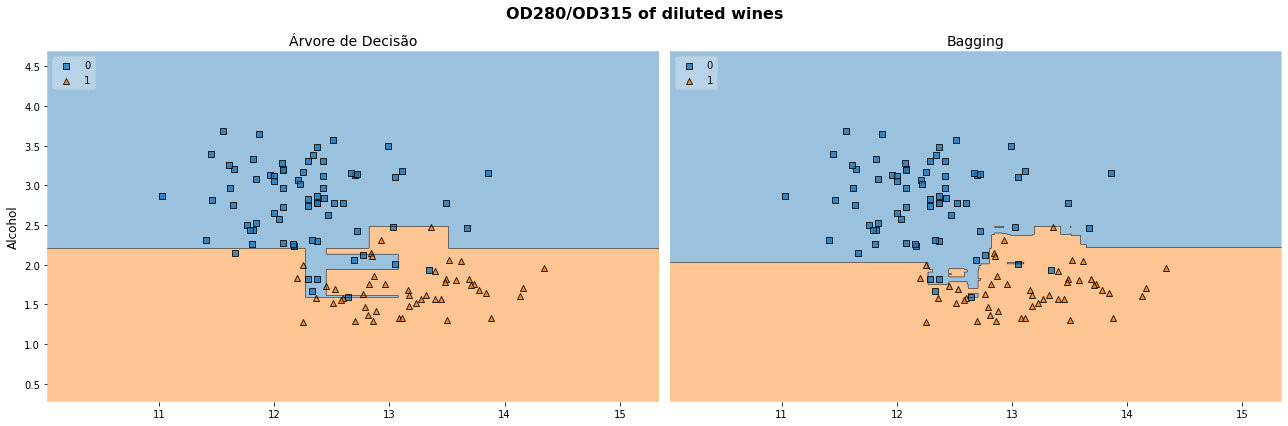

In [50]:
from mlxtend.plotting import plot_decision_regions

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
plt.suptitle("OD280/OD315 of diluted wines", fontsize=16, fontweight='bold')
fig = plot_decision_regions(X=X, y=y, clf=tree, ax=ax1, legend=2)
ax1.set_title('Árvore de Decisão', fontsize=14)
fig = plot_decision_regions(X=X, y=y, clf=bag,  ax=ax2, legend=2)
ax2.set_title('Bagging', fontsize=14)
ax2.set_yticks([])

ax1.set_ylabel('Alcohol', fontsize=12)
ax2.get_yaxis_transform()
plt.tight_layout()
plt.show()

Vimos apenas um exemplo muito simples de *bagging*. Na prática, as tarefas de classificação mais complexas e a alta dimensionalidade de um conjunto de dados podem facilmente levar ao *overfitting* em árvores de decisão únicas, e é aí que o algoritmo de *bagging* pode realmente aproveitar seus pontos fortes e fazer a diferença.

Finalmente, devemos notar que o algoritmo de *bagging* pode ser uma abordagem eficaz para reduzir a variância de um modelo. No entanto, o *bagging* é ineficaz na **redução do viés** do modelo, ou seja, modelos muito simples para capturar bem a tendência nos dados. É por isso que queremos realizar o *bagging em um conjunto de classificadores **com baixo viés**, por exemplo, árvores de decisão não podadas.

### Aproveitando alunos fracos por meio de reforço adaptativo

Nós já discutimos sobre os métodos de *ensemble*, agora discutiremos o *boosting*, com foco especial em sua implementação mais comum: *Adaptive Boosting (AdaBoost)*.

No *boosting*, o *ensemble* consiste em classificadores de base muito simples, também chamados de **weak learners** (aprendizes fracos), que geralmente têm apenas uma pequena vantagem de desempenho em relação à adivinhação aleatória – um exemplo típico de um aprendiz fraco é um galho da árvore de decisão. O conceito-chave por trás do reforço é focar em exemplos de treinamento que são difíceis de classificar, ou seja, permitir que os aprendizes fracos aprendam posteriormente com exemplos de treinamento mal classificados para melhorar o desempenho do conjunto. A seguir, apresentaremos o procedimento algorítmico por trás do conceito geral de *boosting* e *AdaBoost*. Por fim, usaremos o *scikit-learn* para um exemplo prático de classificação.

### Como funciona o boosting

Em contraste com o *bagging*, a formulação inicial do algoritmo de reforço usa subconjuntos aleatórios de exemplos de treinamento extraídos do conjunto de dados de treinamento **sem substituição**; o procedimento de reforço original pode ser resumido nas quatro etapas principais a seguir:
1. Desenhe um subconjunto aleatório (amostra) de exemplos de treinamento, 𝑑1, sem substituição do conjunto de dados de treinamento, *D*, para treinar um aprendiz fraco, 𝐶1.
2. Desenhe um segundo subconjunto de treinamento aleatório, 𝑑2 , sem substituição do conjunto de dados de treinamento e adicione 50% dos exemplos que foram anteriormente classificados incorretamente para treinar um aprendiz fraco, 𝐶2.
3. Encontre os exemplos de treinamento, 𝑑3, no conjunto de dados de treinamento, *D*, dos quais 𝐶1 e 𝐶2 discordam, para treinar um terceiro aprendiz fraco, 𝐶3 .
4. Combine os aprendizes fracos 𝐶1, 𝐶2 e 𝐶3 utilizando a votação majoritária.

Em contraste com o procedimento de reforço original descrito aqui, o *AdaBoost* usa o conjunto de dados de treinamento completo para treinar os aprendizes fracos, onde os exemplos de treinamento são reponderados em cada iteração para construir um classificador forte que aprende com os erros dos aprendizes fracos anteriores no conjunto.

### Aplicando *AdaBoost* usando scikit-learn
Foi apresentado o *AdaBoost* em poucas palavras. Indo para a parte mais prática, vamos agora treinar um classificador de conjunto *AdaBoost* via *scikit-learn*. Usaremos o subconjunto *Wine* que usamos anteriormente para treinar o metaclassificador *bagging*. Por meio do atributo *base_estimator*, treinaremos o *AdaBoostClassifier* em 500 ramos de uma árvore de decisão:

In [51]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [52]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

Decision tree train/test accuracies 0.916/0.875


Como você pode ver, o ramo da árvore de decisão parece não ajustar os dados de treinamento em contraste com a árvore de decisão não podada que vimos anteriormente.

In [53]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('AdaBoost train/test accuracies %.3f/%.3f'
      % (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.917


Aqui, você pode ver que o modelo *AdaBoost* prevê todos os rótulos de classe do conjunto de dados de treinamento corretamente e também mostra um desempenho do conjunto de dados de teste ligeiramente aprimorado em comparação ao ramo da árvore de decisão. No entanto, você também pode ver que introduzimos variação adicional por nossa tentativa de reduzir o viés do modelo – uma lacuna maior entre o treinamento e o desempenho do teste.

Embora tenhamos usado outro exemplo simples para fins de demonstração, podemos ver que o desempenho do classificador *AdaBoost* é ligeiramente aprimorado em comparação com o ramo da árvore de decisão e obteve pontuações de precisão muito semelhantes às do classificador *bagging* que treinamos anteriormente. No entanto, devemos observar que é considerado uma prática ruim <u>selecionar um modelo com base no uso repetido do conjunto de dados de teste</u>. A estimativa do desempenho da generalização pode ser excessivamente otimista.

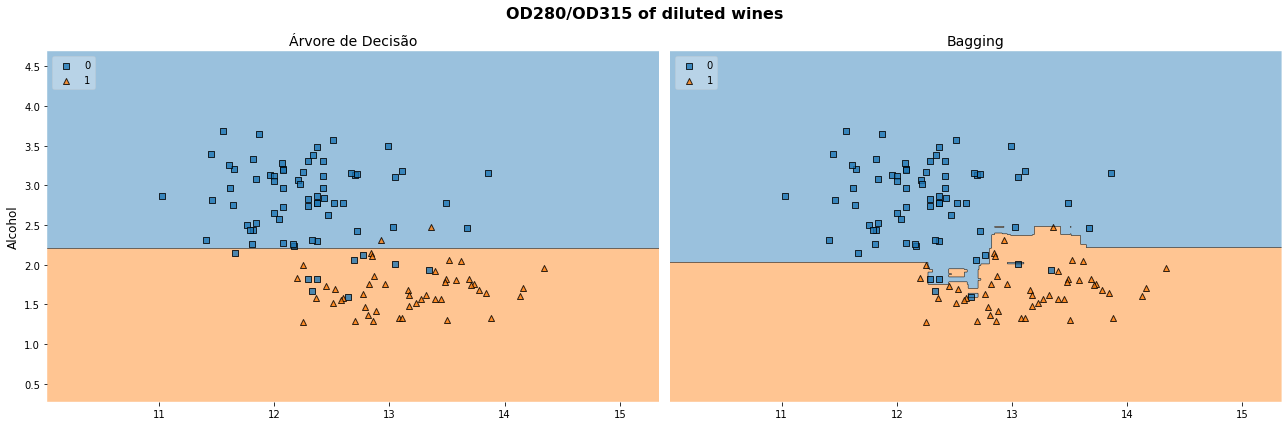

In [54]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
plt.suptitle("OD280/OD315 of diluted wines", fontsize=16, fontweight='bold')
fig = plot_decision_regions(X=X, y=y, clf=tree, ax=ax1, legend=2)
ax1.set_title('Árvore de Decisão', fontsize=14)
fig = plot_decision_regions(X=X, y=y, clf=bag,  ax=ax2, legend=2)
ax2.set_title('Bagging', fontsize=14)
ax2.set_yticks([])

ax1.set_ylabel('Alcohol', fontsize=12)
ax2.get_yaxis_transform()
plt.tight_layout()
plt.show()

Como considerações finais sobre as técnicas de *ensemble*, vale a pena notar que o *ensemble learning* aumenta a <b>complexidade computacional</b> em comparação com classificadores individuais. Na prática, precisamos pensar cuidadosamente se queremos pagar o preço do aumento dos custos computacionais por uma melhoria relativamente modesta no desempenho preditivo.